<a href="https://colab.research.google.com/github/DasBytes/three-stage-banglish-depression-classifier/blob/main/Banglish_Depression_classifier_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
from google.colab import files
uploaded = files.upload()


Saving Banglish depression dataset.csv to Banglish depression dataset (2).csv



MODEL PERFORMANCE
Accuracy : 0.9452395768512757
Precision: 0.9454100976323687
Recall   : 0.9452193521172194
F1-score : 0.9452562988153055


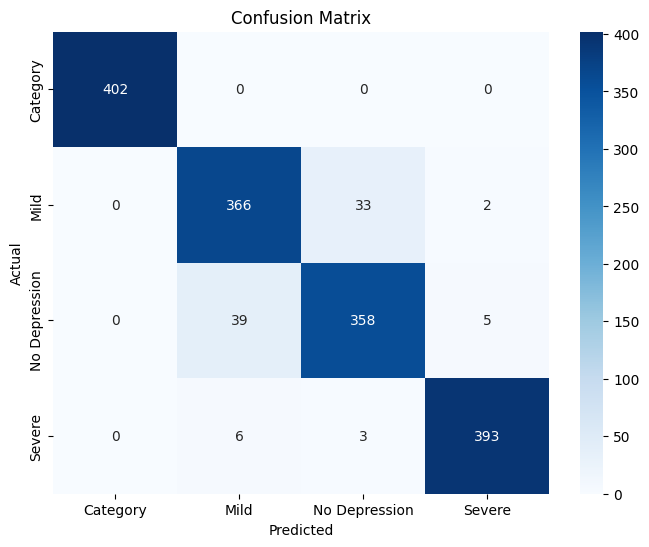

KeyboardInterrupt: Interrupted by user

In [36]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle, resample
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack

# ---------------------------
# Load Banglish Depression Dataset
# ---------------------------
file_name = list(uploaded.keys())[0]       # <-- matches your upload
df = pd.read_csv(file_name, header=None, names=["Category", "Sentence"])

df.dropna(subset=["Sentence", "Category"], inplace=True)
df["Category"] = df["Category"].str.strip()
df = shuffle(df, random_state=42)

# ---------------------------
# Context augmentation
# ---------------------------
extra_data = [
    {'Sentence': 'ami ajke bajare jabo', 'Category': 'No Depression'},
    {'Sentence': 'ami office e jabo', 'Category': 'No Depression'},
    {'Sentence': 'ajke weather ta nice', 'Category': 'No Depression'},
    {'Sentence': 'ami valo achi', 'Category': 'No Depression'},
    {'Sentence': 'shobai kemon acho', 'Category': 'No Depression'},
    {'Sentence': 'alhamdulillah bhalo achi', 'Category': 'No Depression'},
    {'Sentence': 'ami suicide korbo', 'Category': 'Severe'},
    {'Sentence': 'ami ar bachbo na', 'Category': 'Severe'},
    {'Sentence': 'goodbye earth', 'Category': 'Severe'},
    {'Sentence': 'amar life ta khub kharap', 'Category': 'Mild'},
    {'Sentence': 'valolage na kichu', 'Category': 'Mild'},
    {'Sentence': 'sobai keno chole jay', 'Category': 'Mild'},
    {'Sentence': 'ami ar kichu korte parbo na', 'Category': 'No Depression'},
    {'Sentence': 'ami khub stressed feel kortesi', 'Category': 'Mild'}
]

df = pd.concat([df, pd.DataFrame(extra_data)], ignore_index=True)

# ---------------------------
# Text Cleaning
# ---------------------------
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-zA-Zআ-হ0-9\s]", " ", text)
    return re.sub(r"\s+", " ", text).strip()

df["Cleaned"] = df["Sentence"].apply(clean_text)

# ---------------------------
# Numeric Features
# ---------------------------
positive_words = ['valo', 'bhalo', 'happy', 'alhamdulillah', 'nice']
negative_words = ['kharap', 'na', 'tired', 'stress', 'sad', 'suicide', 'khub']

def count_words(text, word_list):
    return sum(text.count(w) for w in word_list)

df["sent_len"] = df["Cleaned"].apply(lambda x: len(x.split()))
df["pos_count"] = df["Cleaned"].apply(lambda x: count_words(x, positive_words))
df["neg_count"] = df["Cleaned"].apply(lambda x: count_words(x, negative_words))

# ---------------------------
# Balance Classes
# ---------------------------
classes = df["Category"].unique()
max_size = df["Category"].value_counts().max()

df_balanced = pd.concat([
    resample(df[df["Category"] == cls], replace=True, n_samples=max_size, random_state=42)
    for cls in classes
])

df_balanced = shuffle(df_balanced, random_state=42)

# ---------------------------
# Train–Test Split
# ---------------------------
X_text = df_balanced["Cleaned"]
X_num = df_balanced[["sent_len", "pos_count", "neg_count"]].values
y = df_balanced["Category"]

scaler = StandardScaler()
X_num = scaler.fit_transform(X_num)

X_train_text, X_test_text, y_train, y_test, X_train_num, X_test_num = train_test_split(
    X_text, y, X_num, test_size=0.2, random_state=42, stratify=y
)

# ---------------------------
# TF-IDF Vectorization (1–4 grams)
# ---------------------------
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,4))
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

# Combine features
X_train_combined = hstack([X_train_tfidf, X_train_num])
X_test_combined = hstack([X_test_tfidf, X_test_num])

# ---------------------------
# Train Logistic Regression
# ---------------------------
model = LogisticRegression(
    max_iter=2000,
    multi_class='multinomial',
    solver='sag',
    C=30,
    random_state=42
)

model.fit(X_train_combined, y_train)

# ---------------------------
# Evaluation
# ---------------------------
y_pred = model.predict(X_test_combined)

accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="macro")
recall    = recall_score(y_test, y_pred, average="macro")
f1        = f1_score(y_test, y_pred, average="macro")

print("\nMODEL PERFORMANCE")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)

# ---------------------------
# Confusion Matrix
# ---------------------------
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ---------------------------
# LIVE Prediction Function
# ---------------------------
def predict_live(text):
    clean = clean_text(text)
    tfidf_vec = vectorizer.transform([clean])
    sent_len = len(clean.split())
    pos_count = count_words(clean, positive_words)
    neg_count = count_words(clean, negative_words)
    num_feat = scaler.transform([[sent_len, pos_count, neg_count]])
    combined = hstack([tfidf_vec, num_feat])
    pred = model.predict(combined)[0]
    prob = np.max(model.predict_proba(combined)) * 100
    return pred, prob

txt = input("Enter text for prediction: ").strip()

if txt:
    pred, conf = predict_live(txt)
    print(f"Prediction: {pred} | Confidence: {conf:.2f}%")


